## Aggregate data to daily and hourly (2017 data)

In [2]:
library(sqldf)
library(tidyverse)
library(lubridate)
airq<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/dataMar2017.csv",stringsAsFactors = FALSE)
colnames(airq)<-gsub("payload.", "", colnames(airq))
airq$datetime<-as.POSIXct(airq$time,format="%Y-%m-%dT%H:%M:%S")
airq$date<-as.Date(airq$time,format="%Y-%m-%d")
airq$hour<-hour(airq$datetime)
dailyairq<-aggregate(airq["pm25"], by=airq[c("id","date")], FUN=mean,na.rm=TRUE)
hourlyairq<-aggregate(airq["pm25"], by=airq[c("id","date","hour")], FUN=mean,na.rm=TRUE)

ERROR: Error in hour(airq$datetime): could not find function "hour"


## Prepare dailyairq

In [22]:
dailyairq<- dailyairq[order(dailyairq$date, dailyairq$id),]

In [23]:
datefull<-seq(from=min(dailyairq$date),to=max(dailyairq$date), by="day")

In [24]:
sensor_newdaily<-sqldf('select distinct(id) from dailyairq')

In [25]:
fulldata<-merge(sensor_newdaily,datefull)
colnames(fulldata)[2]<-'timepos'

In [29]:
newdaily<-sqldf('select f.id,f.timepos,n.pm25 from fulldata f LEFT JOIN dailyairq n ON f.id = n.id AND f.timepos=n.date')

## Load sensorlist

In [18]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/Jupyter/master/sensorlist_with_height.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",3]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",3]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",3]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",3]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

## Plot data

In [58]:
newdaily<-newdaily[!newdaily$id=='CU-S0201',]
newdaily<-newdaily[!newdaily$id=='CU-S0202',]
newdaily<-newdaily[!newdaily$id=='CU-S0203',]
newdaily<-newdaily[!newdaily$id=='CU-S0204',]
newdaily[newdaily$id=="CU-S00103",1]<-"CU-S0103"
newdaily[newdaily$id=="CU-S00104",1]<-"CU-S0104"

Warning message:
“Removed 254 rows containing missing values (geom_path).”

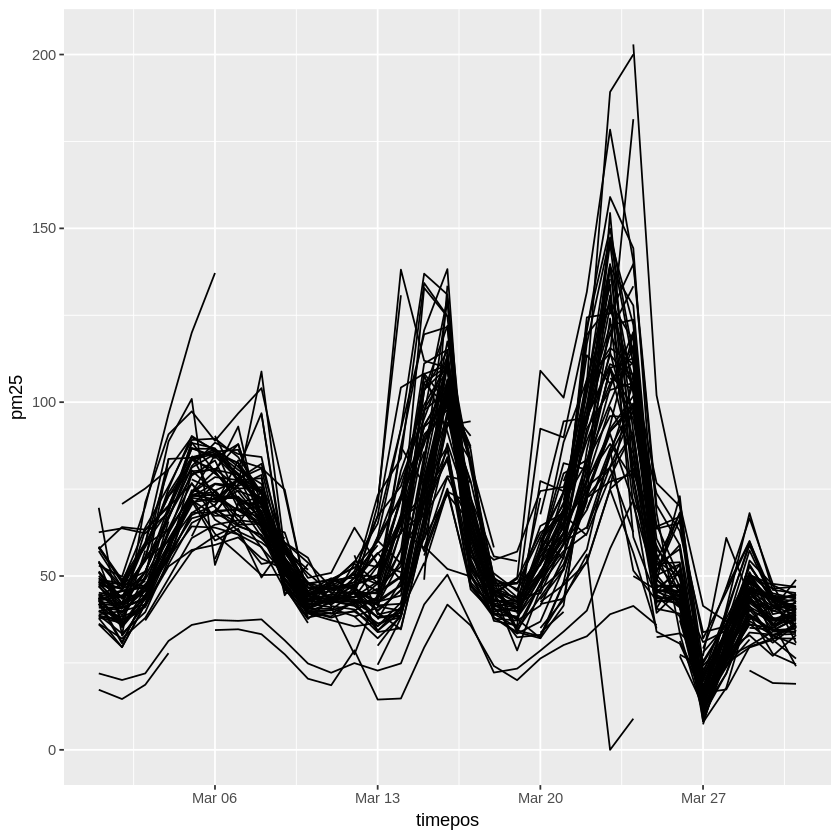

In [59]:
ggplot(data=newdaily, aes(x=timepos, y=pm25, group=id)) + geom_line()

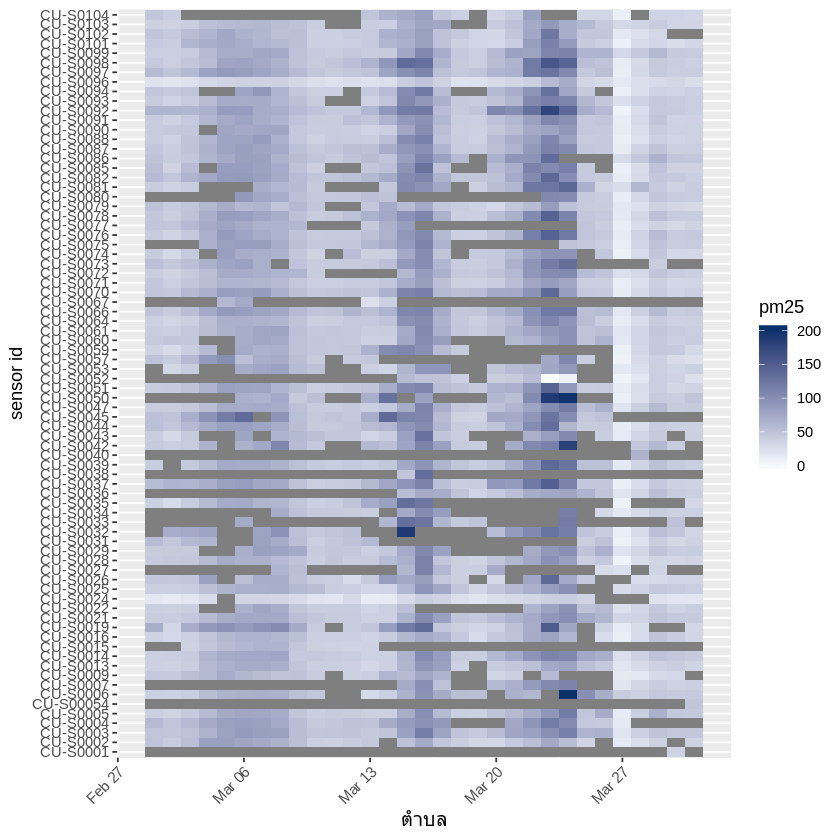

In [60]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")
ggplot(newdaily, aes(y=id,x=timepos)) +geom_tile(aes(fill = pm25))+ scale_fill_gradient(low=colorsetting[1],high=colorsetting[9])+labs(y = "sensor id",x="ตำบล")+theme(axis.text.x = element_text(angle = 45, hjust = 1))

Warning message:
“Removed 166 rows containing non-finite values (stat_summary).”

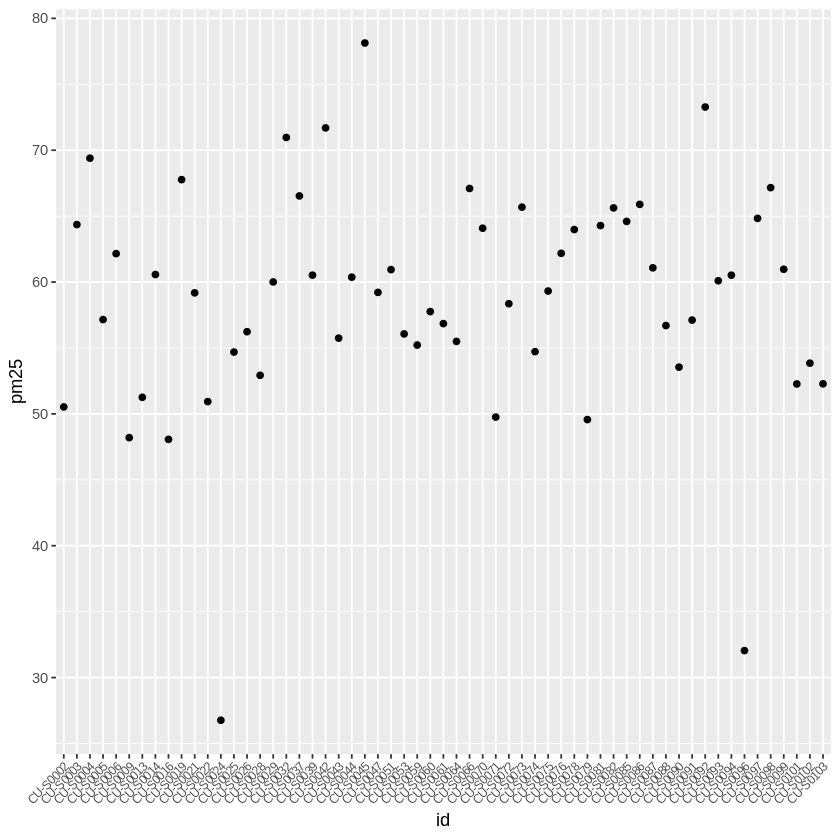

In [72]:
count_na<-aggregate(pm25 ~ id, data=newdaily, function(x) {sum(is.na(x))}, na.action = NULL)
sensorFull<-count_na$id[which(count_na$pm25<10)]
newdaily<-subset(newdaily,id %in% sensorFull)
ggplot(newdaily, aes(x=id, y=pm25)) + stat_summary(fun.y="mean", geom="point")+theme(axis.text.x = element_text(size=7,angle = 45, hjust = 1))

In [75]:
#ggsave("2017avg.png",width=6)

Saving 6 x 6.67 in image
Warning message:
“Removed 166 rows containing non-finite values (stat_summary).”

In [76]:
#write.csv(newdaily, file = "2017MarAVG.csv")